#**Recurrent Neural Networks for sentiment analysis**

We will use the IMDB dataset containing the text of some reviews and the sentiment (positive or negative) given by the authors of the reviews. The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.

We will first develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

#### **IMD Dataset loading and pre-processing**

The dataset contains 50000 movie reviews from IMDB, labeled by sentiment: positive/negative. 

Reviews are pre-processed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.

In [ ]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

# By default, the load_data method returns a breakdown of the dataset into training and test sets. 
# Both these sets contain 25,000 samples. 
# To also have a validation set, we split the test set in half.

(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

According to the Keras requirements, a RNN model has to be fed with input sequences having the same length: we will create a 2D array of 25,000 rows (one per review) and 500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

#### **Word encoding/decoding**

In [ ]:
# Word index (word --> word_id)
word_index = keras.datasets.imdb.get_word_index()

# Word reverse index (word_id --> word)
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}

# Add some special word_ids
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out of the vocabulary of the first 10000 most common words
reverse_index[3] = "<unk>" # unknown (all the other symbols, i.e. not words)

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

In [ ]:
# Example:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0] # positive review

1

##**Simple Recurrent Neural Network (RNN)**

In [ ]:
# The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10)) 
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid")) 

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Since the model performs a binary classification task, we used the sigmoid activation for the output layer and the binary cross-entropy as loss function.

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 26s 134ms/step - loss: 0.6055 - accuracy: 0.6756 - val_loss: 0.4832 - val_accuracy: 0.7722
Epoch 2/10
196/196 [==============================] - 25s 127ms/step - loss: 0.3652 - accuracy: 0.8431 - val_loss: 0.4060 - val_accuracy: 0.8202
Epoch 3/10
196/196 [==============================] - 25s 127ms/step - loss: 0.2763 - accuracy: 0.8886 - val_loss: 0.5600 - val_accuracy: 0.7090
Epoch 4/10
196/196 [==============================] - 25s 128ms/step - loss: 0.2228 - accuracy: 0.9118 - val_loss: 0.4012 - val_accuracy: 0.8371
Epoch 5/10
196/196 [==============================] - 25s 128ms/step - loss: 0.1309 - accuracy: 0.9554 - val_loss: 0.4526 - val_accuracy: 0.8338
Epoch 6/10
196/196 [==============================] - 25s 128ms/step - loss: 0.0810 - accuracy: 0.9753 - val_loss: 0.5031 - val_accuracy: 0.8286
Epoch 7/10
196/196 [==============================] - 25s 128ms/step - loss: 0.0471 - accuracy: 0.9876 - val_loss: 0.5848 - val_ac

391/391 - 8s - loss: 0.6438 - accuracy: 0.8371
accuracy: 83.71%


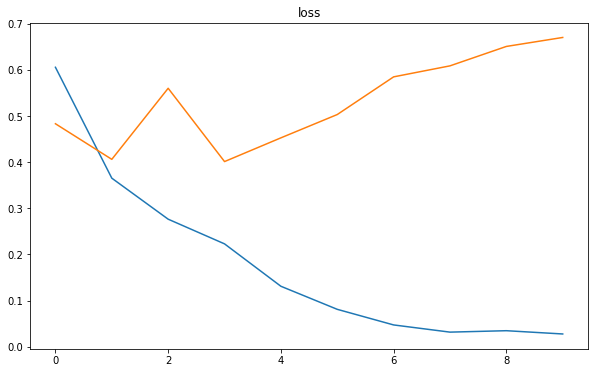

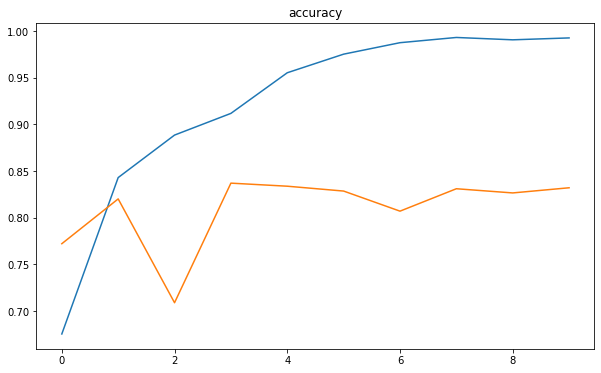

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##**Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)**

To perform a fair comparison, I've to use approximately half of the units used for the Simple RRN. In particulat, if we look at LSTM and GRU classes, the "units" argument of keras layer is described as the positive integer that corresponds to the dimesionality of the output space i.e. the number of hidden units.

For a Simple RNN with input size $n$ and number of hidden states $d$ (i.e units), we have a matrix U of dimension $ n\times d$ that multiplies the input $ x^{t} $ , a matrix W of dimension $ d\times d $ that multiplies $ h^{t-1} $ and a matrix V of dimension $ d\times m $ that multiplies $ h^{t} $ where $m$ is the dimension of the output.
So the number of parameter is $ nd + d^{2} + dm = d(n + d + m)$.

On the other hand, for a LSTM with input size $n$ and number of hidden states $d$ , we have 3 Gates (input, forget, output) + 1 Memory Cell and, for each of these elements, we have a weight matrix of dimension $ n\times d $ that multiplies the input $ x^{t} $ and a weight matrix of dimension $ d\times d$ that multiplies the hidden state $ h^{t-1} $. So the total number of parameters, by considering $n+1$ because of biases, is $4((n + 1)d + d^{2}) = 4d(n + 1 + d) $.

In conclusion, if we consider $\frac{d}{2}$ units we obtain for LSTM a number of parameters that is $ 4\frac{d}{2}(n + 1 + \frac{d}{2}) = 2nd + 2d + d^{2} $ that is similar to the one obtained for a Simple RNN with $d$ units: $ nd + d^{2} + dm $.

Finally, GRU is a simplified version of LSTM with just two Gates $z^{t}$ and $r^{t}$ (update and reset) and a hidden unit $h^{t}$: for each of these elements we have a weight matrix of dimension $ n\times d $ that multiplies the input $ x^{t} $ , a weight matrix of dimension $ d\times d$ that multiplies the hidden state $ h^{t-1} $ and a weight matrix of dimension $d\times m$ that multiplies the Hadamard product of $ r^{t} $ and $ h^{t-1} $. Thus, we have a number of parameters (by considering $n+1$ because of biases) that is very similar to the one of LSTM: $3((n+1)d+d^{2}+dm)=3d(n+1+d+m)$ and we can still use approximately $\frac{d}{2}$ units to perform a fair comparison with Simple RNN.

In our case, for the Simple RNN we considered $ d=32, n = 10, m=1 $ and obtained $d(n + d + m) = 32*(10+32+1) = 1376$ parameters.

For the LSTM I considered $d=14$ and obtained $4d(n+1+d) = 4*14*(10+1+14) = 1400$ parameters.

For the GRU I considered $d=16$ and obtained $3d(n+1+d+m) = 3*16*(10+1+16+1) = 1344$ parameters.



#### **Comparable LSTM**

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 14)                1400      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 48s 244ms/step - loss: 0.5803 - accuracy: 0.6926 - val_loss: 0.4384 - val_accuracy: 0.8234
Epoch 2/10
196/196 [==============================] - 51s 259ms/step - loss: 0.3357 - accuracy: 0.8668 - val_loss: 0.3377 - val_accuracy: 0.8630
Epoch 3/10
196/196 [==============================] - 50s 256ms/step - loss: 0.2544 - accuracy: 0.9068 - val_loss: 0.3400 - val_accuracy: 0.8567
Epoch 4/10
196/196 [==============================] - 51s 258ms/step - loss: 0.2009 - accuracy: 0.9313 - val_loss: 0.3259 - val_accuracy: 0.8689
Epoch 5/10
196/196 [==============================] - 51s 262ms/step - loss: 0.1697 - accuracy: 0.9439 - val_loss: 0.3595 - val_accuracy: 0.8636
Epoch 6/10
196/196 [==============================] - 51s 260ms/step - loss: 0.1427 - accuracy: 0.9546 - val_loss: 0.3844 - val_accuracy: 0.8614
Epoch 7/10
196/196 [==============================] - 50s 255ms/step - loss: 0.1289 - accuracy: 0.9604 - val_loss: 0.3876 - val_ac

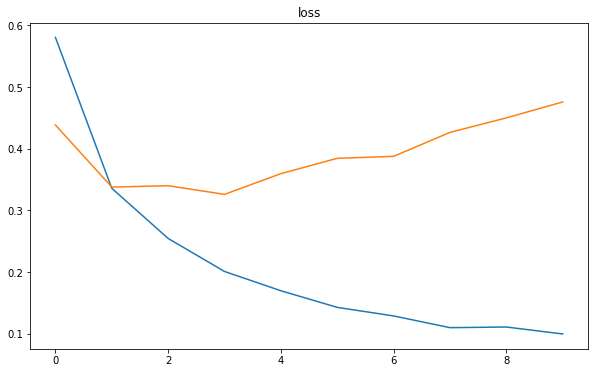

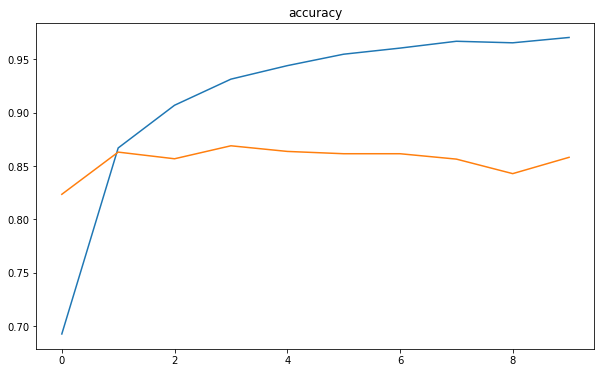

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)
plot_accuracy(history)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#### **Comparable GRU**

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_9 (GRU)                  (None, 16)                1344      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
196/196 [==============================] - 47s 238ms/step - loss: 0.5780 - accuracy: 0.6760 - val_loss: 0.4025 - val_accuracy: 0.8210
Epoch 2/10
196/196 [==============================] - 50s 253ms/step - loss: 0.3111 - accuracy: 0.8714 - val_loss: 0.3340 - val_accuracy: 0.8618
Epoch 3/10
196/196 [==============================] - 49s 249ms/step - loss: 0.2402 - accuracy: 0.9080 - val_loss: 0.3432 - val_accuracy: 0.8619
Epoch 4/10
196/196 [==============================] - 50s 255ms/step - loss: 0.2101 - accuracy: 0.9232 - val_loss: 0.3478 - val_accuracy: 0.8630
Epoch 5/10
196/196 [==============================] - 50s 255ms/step - loss: 0.1697 - accuracy: 0.9411 - val_loss: 0.3651 - val_accuracy: 0.8564
Epoch 6/10
196/196 [==============================] - 50s 253ms/step - loss: 0.1481 - accuracy: 0.9509 - val_loss: 0.4018 - val_accuracy: 0.8569
Epoch 7/10
196/196 [==============================] - 50s 253ms/step - loss: 0.1344 - accuracy: 0.9551 - val_loss: 0.4046 - val_ac

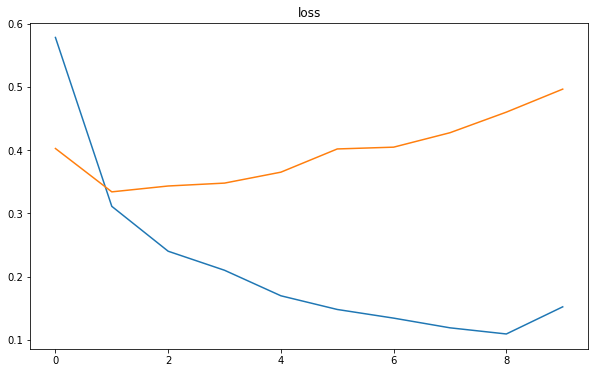

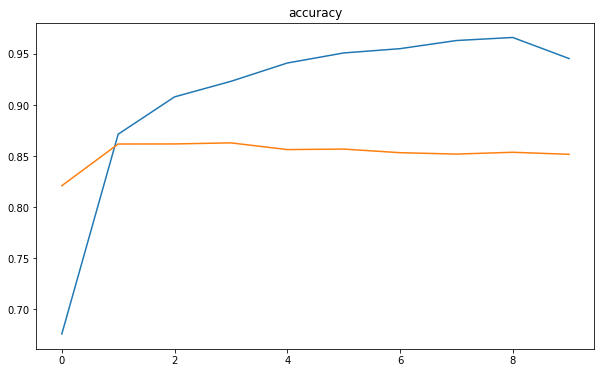

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

plot_loss(history)
plot_accuracy(history)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#### **Discussion**

- Training Time:

Training time for the Simple RNN is very low (about 25 seconds per epoch) compared to the ones of LSTM (about 51 seconds per epoch) and GRU (50 seconds per epoch). In fact the architectures of the last two models are more complex than the first one: the LSTM block contains a block input/output, a Memory Cell and three Gates, while the Simple RNN contains just the block input/output. Moreover, in LSTM, whether to make a gate on or off is not decided a priori, but is learned during the training through the computation of an intricate system of derivatives! For what concerns the GRU, it has a single gating unit that simultaneously controls the forgetting factor and the decision to update the state unit: the update gate selects whether $h^{t}$ is updated or not using a new hidden state $\tilde{h}$ and the reset gate decides whether the previous hidden state $h^{t-1}$ is ignored. So, also in this case we have a Gradient Descent procedure to update the weights that is more complex (and consequently requires more time) than in case of Simple RNN. Since GRU has a bit simpler structure than LSTM, it trains a little faster.

- Performance:

Obviously LSTM and GRU reaches better results than Simple RNN in terms of accuracy (86.1% and 85.5% versus 83.7%) and loss (0.45 and 0.49 versus 0.64); in fact these models are studied to reduce (it's not possible to completely avoid) the vanishing of the gradient: their architectures allow the network to "remember" relevant information for a long period of time. In particular, in the Simple RNN the gradient gets down-sized by the multiplication with the Jacobian of sigmoidal function, while in the LSTM it doesn't happen thanks to the Linear Memory Cell that integrates input information through time.
In conclusion, GRU has a simpler structure than LSTM and it results in a little faster train but also a bit worse performance: it could be a good compromise between Simple RNN and LSTM.

##**Bidirectional LSTM**



In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 83s 532ms/step - loss: 0.5520 - accuracy: 0.7074 - val_loss: 0.3351 - val_accuracy: 0.8652
Epoch 2/10
157/157 [==============================] - 83s 526ms/step - loss: 0.2988 - accuracy: 0.8826 - val_loss: 0.3410 - val_accuracy: 0.8536
Epoch 3/10
157/157 [==============================] - 82s 524ms/step - loss: 0.3562 - a

391/391 - 20s - loss: 0.4028 - accuracy: 0.8559
accuracy: 85.59%


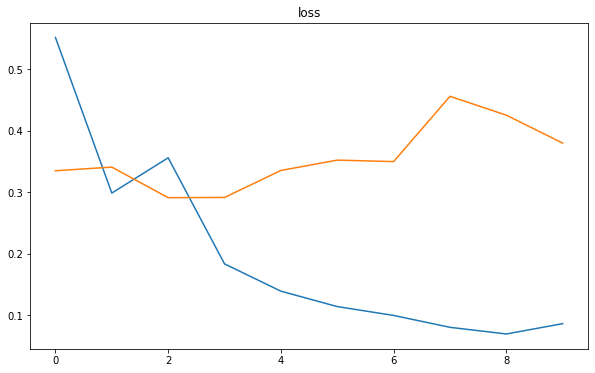

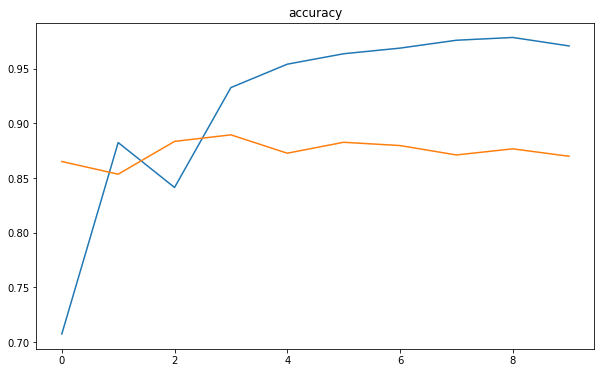

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

#### **Dropout**
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.8))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
157/157 [==============================] - 84s 537ms/step - loss: 0.6212 - accuracy: 0.6387 - val_loss: 0.4475 - val_accuracy: 0.8260
Epoch 2/10
157/157 [==============================] - 83s 529ms/step - loss: 0.4138 - accuracy: 0.8217 - val_loss: 0.3154 - val_accuracy: 0.8746
Epoch 3/10
157/157 [==============================] - 82s 521ms/step - loss: 0.3977 - accuracy: 0.8197 - val_loss: 0.3544 - val_accuracy: 0.8450
Epoch 4/10
157/157 [==============================] - 82s 520ms/step - loss: 0.3040 - accuracy: 0.8733 - val_loss: 0.3085 - val_accuracy: 0.8696
Epoch 5/10
157/157 [==============================] - 81s 519ms/step - loss: 0.2707 - accuracy: 0.8912 - val_loss: 0.2746 - val_accuracy: 0.8920
Epoch 6/10
157/157 [==============================] - 81s 516ms/step - loss: 0.2561 - accuracy: 0.8966 - val_loss: 0.2881 - val_accuracy: 0.8856
Epoch 7/10
157/157 [==============================] - 81s 513ms/step - loss: 0.2401 - accuracy: 0.9061 - val_loss: 0.3176 - val_ac

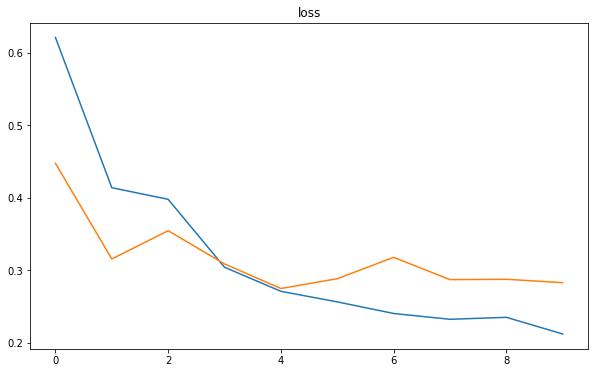

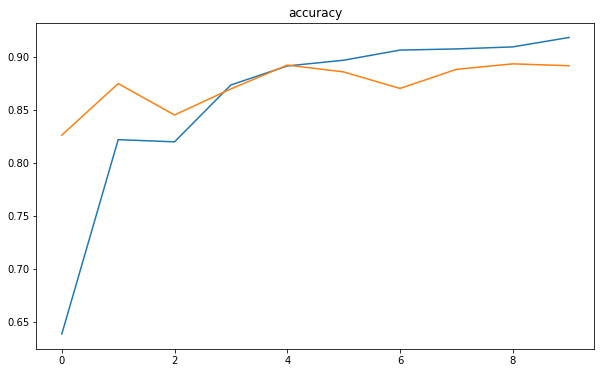

In [ ]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

In this case, the best option is to add a Dropout layer to the input layer. I chose the probability of 0.8 that allows to reach an accuracy of 88.3% while the model without Dropout reaches 85.6% of accuracy.

In fact, Dropout is a regularization tecnique which reduces overfitting: if we consider the graphs of accuracy and loss of the model without Dropout, we can observe an high gap (generalization gap) between the training error and the test error, in particular we have a gap of about 0.3 for the loss and a gap of more than 0.1 for the accuracy. This means that the model "memorizes" somehow the training data but it is not able to achieve a good performance also with unknown data.

On the other hand, the model with Dropout gets a gap of less than 0.1 for the loss and a gap of less than 0.05 for accuracy. In fact the idea of Dropout is to approximate Bagging by using a mini-batch based algorithm: a binary mask is applied to all input and hidden units and the probability of including a unit is a hyper-parameter (the higher it is the more regularization we gat and, as I said, I chose 0.8). At every iteration the model computes Gradient Descent not on the original network but on a random member of the ensemble and the prediction is the mean over all the models (all the masks).

I chose to apply the Dropout to the input layer because it's the layer with the majority of parameters (100000) and it results - empirically - the best option.



#### **Other solutions for reducing overfitting**

To reduce the phenomenon of overfitting and get a better accuracy, we can also modify some other hyper-parameters of the model:
* dimension of traning dataset (validation split)
* number of units of LSTM
* batches dimension
* number of epochs

In order to find the best combination of values for the hyper-parameters, I performed an experimental study: at first I changed one hyper-parameter at time and then I modified more than one hyper-parameter by taking into account the previous results. I represented the empirical results in the following table and I reported just the modified values with respect to the first row:

> validation_split | LSTM units | batch_size | epochs | accuracy
> --- | --- | --- | --- | --- 
> 0.2 | 32 | 128 | 10 | 85.6%
> 0.1 | | | | 86.2% $\checkmark$
> 0.3 | | | | 85.3%
> 0.4 | | | | 84.7%
>  | 8 | | | 85.1%
>  | 16 | | | 85.8%
>  | 64 | | | 85.6%
>  | 128 | | | 85.5%
>  | 256 | | | 80.5%
>  | | 32 | | 85.5%
>  | | 64 | | 84.9%
>  | | 256 | | 85.8%
>  | | 512 | | 86.8% $\checkmark$
>  | | 1024 | | 84.2%
>  | | | 5 | 87.0% $\checkmark$
>  | | | 7 | 86.7% $\checkmark$
>  | | | 15 | 85.3%

> validation_split | LSTM units | batch_size | epochs | accuracy
> --- | --- | --- | --- | --- 
> 0.2 | 32 | 128 | 10 | 85.6%
> 0.1 | | | 5 | 87.4%
> 0.1 | | | 7 | 87.4%
>  | | 512 | 5 | 83.2%
>  | | 512 | 7 | 87.4%
> 0.1 | | 512 | | 86.5%
> 0.1 | | 512 | 5 | 86.5%
> 0.1 | | 512 | 7 | 87.4%

I obtained a slightly better performance by reducing (from 0.2 to 0.1) the fraction of data to be used as validation set: the validation_split parameter indicates the fraction of data on which the model will not train and the lower it is the higher the dimension of training data is. In this way the model can learn on more data and the overfitting tends to be reduced.

I found out that 32 is a good value for the number of units of LSTM: when I considered a too low value (e.g 8) or too high value (e.g. 256) I obtained bad performances, but when I chose values such as 16, 64, 128 I obtained more or less the same performance as the one obtained with 32 units.

With a bigger size of batches such as 512 we obtain more accuracy, in fact the gradient of the loss function is computed on a bigger subset of the training set and, consequently, it is more precise. However, by choosing a bigger batch_size, I did not notice - empirically - an increment in overfitting; in fact, the mini-batch approach has anyway a regularization effect because the model is resilient to small perturbations in the gradient.

Moreover, Early Stopping is very useful to reduce overfitting: I set the number of epochs to be lower than 10 (e.g. 5 or 7) and I obtained a better accuracy. In fact in most cases training set loss will go down more and more during the epochs, while the validation set loss decreases up to a certain epoch and then starts to oscillate. The idea is to stop the training if there's no improvement of validation set loss for a certain number of epochs.

In conclusion, to reduce overfitting, I set validation_split = 0.1, batch_size = 512, epochs = 7. This model is able to reach about 87.4% of accuracy with a lower generalization gap (in both loss and accuracy plots) than the original model with validation_split = 0.2, batch_size = 128, epochs = 10.
The implementation is the following:


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________


Epoch 1/7
44/44 [==============================] - 62s 1s/step - loss: 0.6790 - accuracy: 0.5920 - val_loss: 0.6312 - val_accuracy: 0.7716
Epoch 2/7
44/44 [==============================] - 68s 2s/step - loss: 0.5492 - accuracy: 0.7619 - val_loss: 0.4731 - val_accuracy: 0.8108
Epoch 3/7
44/44 [==============================] - 64s 1s/step - loss: 0.4111 - accuracy: 0.8459 - val_loss: 0.3896 - val_accuracy: 0.8308
Epoch 4/7
44/44 [==============================] - 63s 1s/step - loss: 0.3021 - accuracy: 0.8868 - val_loss: 0.3334 - val_accuracy: 0.8628
Epoch 5/7
44/44 [==============================] - 63s 1s/step - loss: 0.2472 - accuracy: 0.9112 - val_loss: 0.3786 - val_accuracy: 0.8556
Epoch 6/7
44/44 [==============================] - 63s 1s/step - loss: 0.2012 - accuracy: 0.9320 - val_loss: 0.3333 - val_accuracy: 0.8728
Epoch 7/7
44/44 [==============================] - 64s 1s/step - loss: 0.1851 - accuracy: 0.9389 - val_loss: 0.3202 - val_accuracy: 0.8756
391/391 - 23s - loss: 0.321

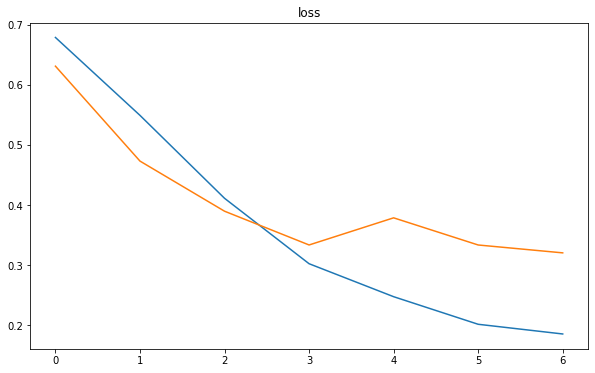

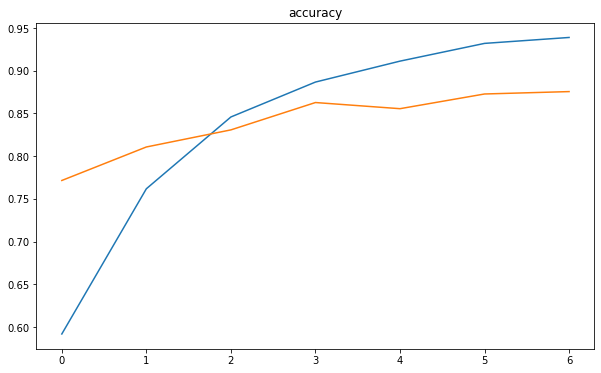

In [ ]:
history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=7, batch_size=512, validation_split=0.1)

plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))